In [1]:
import os
import pandas as pd
from collections import Counter, defaultdict
from venny4py import venny4py
import matplotlib.pyplot as plt
import random

from copy import copy
import numpy as np
from pyteomics import auxiliary as aux
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import rankdata, ttest_ind, ttest_rel, wilcoxon, scoreatpercentile
from scipy.optimize import curve_fit
import scipy

In [2]:
# Install all missing Python libraries!

In [ ]:
# Install modified scikit-learn package presented in the manuscript
!pip install https://github.com/markmipt/scikit-learn/archive/refs/heads/min_groups_leaf.zip --upgrade

In [3]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import roc_auc_score

In [4]:
# Enter here path to project directory
infolder = "/home/mark/ms1_mouse_cohorts/"


In [5]:
path_to_fasta = os.path.join(infolder, 'sprot_mouse_211024_shuffled.fasta')

In [6]:
# Create project directory if it is not exist
if not os.path.isdir(infolder):
    os.makedirs(infolder)

In [7]:
# Move to the project directory
%cd $infolder
%pwd

/home/mark/ms1_mouse_cohorts


'/home/mark/ms1_mouse_cohorts'

In [8]:
# The notebook contains reanalysis of the data provided in the study:
# https://www.mcponline.org/article/S1535-9476(24)00145-2/fulltext

In [ ]:
# All DDA data can be downloaded using wget command below
    
wget ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2024/10/PXD052547/*.raw -b
wget ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2024/10/PXD052549/*.raw -b
wget ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2024/10/PXD052554/*.raw -b
wget ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2024/10/PXD052555/*.raw -b

In [ ]:
# DIA data with PXD052698 and PXD052598 identifiers should be downloaded
# by researcher manually from Panorama public repository

In [ ]:
# For the next step, you should install ThermoRawFileParser (https://github.com/compomics/ThermoRawFileParser)

In [108]:
# Run ThermoRawFileParser for all raw files with an option to extract only MS1 spectra

for fn in os.listdir(infolder):
    if fn.endswith('.raw'):
        infile1 = os.path.join(infolder, fn)
        !ThermoRawFileParser -i $infile1 -L 1 -o $infolder

2024-10-22 12:30:22 INFO Started parsing /home/mark/ms1_mouse_cohorts/20230609_F13.raw
2024-10-22 12:30:25 INFO Processing 50046 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2024-10-22 12:30:38 INFO Finished parsing /home/mark/ms1_mouse_cohorts/20230609_F13.raw
2024-10-22 12:30:38 INFO Processing completed 0 errors, 0 warnings
2024-10-22 12:30:38 INFO Started parsing /home/mark/ms1_mouse_cohorts/20230609_F15.raw
2024-10-22 12:30:42 INFO Processing 50278 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2024-10-22 12:30:55 INFO Finished parsing /home/mark/ms1_mouse_cohorts/20230609_F15.raw
2024-10-22 12:30:55 INFO Processing completed 0 errors, 0 warnings
2024-10-22 12:30:55 INFO Started parsing /home/mark/ms1_mouse_cohorts/20230609_F18.raw
2024-10-22 12:30:59 INFO Processing 50463 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2024-10-22 12:31:12 INFO Finished parsing /home/mark/ms1_mouse_cohorts/20230609_F18.raw
2024-10-22 12:31:12 INFO Processing completed 0 errors, 0 w

In [109]:
# # For the next step, you should install biosaur2 (https://github.com/markmipt/biosaur2)
!pip install biosaur2

In [110]:
# Run biosaur2 for all mzML files to extract peptide isotope clusters.

for fn in os.listdir(infolder):
    if fn.endswith('.mzML'):
        mzmlname = os.path.join(infolder, fn)
        !biosaur2 $mzmlname -minlh 5

     INFO: [12:34:32] Starting file: /home/mark/ms1_mouse_cohorts/20230609_F13.mzML
     INFO: [12:34:33] Number of MS1 scans: 2680
     INFO: [12:34:33] Number of skipped MS1 scans: 0
     INFO: [12:34:48] Detected number of hills: 185927
     INFO: [12:34:51] Number of potential isotope clusters: 83387
     INFO: [12:34:51] Average mass shift between monoisotopic and first 13C isotope: -0.510 ppm
     INFO: [12:34:51] Average mass std between monoisotopic and first 13C isotope: 1.303 ppm
     INFO: [12:34:51] Number of potential isotope clusters after smart mass accuracy for isotopes: 80394
     INFO: [12:34:52] Number of detected isotope clusters: 42689
     INFO: [12:34:55] Feature detection is finished for file: /home/mark/ms1_mouse_cohorts/20230609_F13.mzML
     INFO: [12:34:55] Starting file: /home/mark/ms1_mouse_cohorts/20230609_F8.mzML
     INFO: [12:34:57] Number of MS1 scans: 2682
     INFO: [12:34:57] Number of skipped MS1 scans: 0
     INFO: [12:35:12] Detected number of h

     INFO: [12:38:48] Number of potential isotope clusters after smart mass accuracy for isotopes: 81021
     INFO: [12:38:49] Number of detected isotope clusters: 43066
     INFO: [12:38:51] Feature detection is finished for file: /home/mark/ms1_mouse_cohorts/20230609_F9.mzML
     INFO: [12:38:51] Starting file: /home/mark/ms1_mouse_cohorts/20230609_F17.mzML
     INFO: [12:38:53] Number of MS1 scans: 2685
     INFO: [12:38:53] Number of skipped MS1 scans: 0
     INFO: [12:39:07] Detected number of hills: 179847
     INFO: [12:39:10] Number of potential isotope clusters: 80841
     INFO: [12:39:11] Average mass shift between monoisotopic and first 13C isotope: -0.517 ppm
     INFO: [12:39:11] Average mass std between monoisotopic and first 13C isotope: 1.294 ppm
     INFO: [12:39:11] Number of potential isotope clusters after smart mass accuracy for isotopes: 77899
     INFO: [12:39:12] Number of detected isotope clusters: 41169
     INFO: [12:39:14] Feature detection is finished for f

In [ ]:
# For the next step, you should install ms1searchpy (https://github.com/markmipt/ms1searchpy)
!pip install ms1searchpy

In [ ]:
# For the next step, you should install DeepLC (https://github.com/compomics/DeepLC)
# The recommended version is the clone available at https://github.com/markmipt/DeepLC
!pip install https://github.com/markmipt/DeepLC/archive/refs/heads/alternative_best_model.zip

In [ ]:
# For the next step, you should put protein fasta database into working directory
# The database is placed along this notebook on the github (sprot_human_shuffled.fasta)

In [111]:
# Run ms1searchpy for all *features.tsv files generated by biosaur2

# infasta = os.path.join(infolder, 'sprot_human_shuffled.fasta')
infasta = path_to_fasta
for fn in os.listdir(infolder):
    if fn.endswith('.features.tsv'):
        ftrfile = os.path.join(infolder, fn)
        protfile = ftrfile.replace('.features.tsv', '.features_proteins.tsv')
        if not os.path.exists(protfile):
            !ms1searchpy $ftrfile -d $infasta -sc 1 -i 2 -nproc 8 -mc 0 -cmin 1 -ptol 8 -fdr 5 -ts 2 -ml 1 -deeplc 1 -lmin 7 -mcalib 0 -deeplc_library /tmp/deeplc345.lib

     INFO: [12:40:28] Starting search...
     INFO: [12:40:36] Database information:
     INFO: [12:40:36] Target/Decoy proteins: 17191/17191
     INFO: [12:40:36] Target/Decoy peptides: 427887/427447
     INFO: [12:40:36] Target-Decoy peptide intersection: 0.0 %
     INFO: [12:40:36] Reading file /home/mark/ms1_mouse_cohorts/20230609_F9.features.tsv
     INFO: [12:40:36] Total number of peptide isotopic clusters: 43066
     INFO: [12:40:36] Number of peptide isotopic clusters passed filters: 42399
     INFO: [12:40:36] Running the search ...
     INFO: [12:40:40] Stage 0 search: probability of random match for theoretical peptide = 0.258
     INFO: [12:40:40] Stage 0 search: identified proteins = 81
     INFO: [12:40:40] Running mass recalibration...
     INFO: [12:40:42] Estimated mass shift: -0.382 ppm
     INFO: [12:40:42] Estimated mass sigma: 0.966 ppm
     INFO: [12:40:43] Stage 1 search: probability of random match for theoretical peptide = 0.116
     INFO: [12:40:43] Stage 1 s

     INFO: [12:46:29] Total number of peptide isotopic clusters: 43618
     INFO: [12:46:29] Number of peptide isotopic clusters passed filters: 42988
     INFO: [12:46:29] Running the search ...
     INFO: [12:46:33] Stage 0 search: probability of random match for theoretical peptide = 0.267
     INFO: [12:46:33] Stage 0 search: identified proteins = 71
     INFO: [12:46:33] Running mass recalibration...
     INFO: [12:46:36] Estimated mass shift: -0.840 ppm
     INFO: [12:46:36] Estimated mass sigma: 0.920 ppm
     INFO: [12:46:37] Stage 1 search: probability of random match for theoretical peptide = 0.116
     INFO: [12:46:37] Stage 1 search: identified proteins = 281
     INFO: [12:46:37] Running RT prediction...
     INFO: [12:46:38] First-stage peptides used for RT prediction: 1018
     INFO: [12:46:39] First-stage calibrated RT shift: 0.567 min
     INFO: [12:46:39] First-stage calibrated RT sigma: 6.651 min
     INFO: [12:46:39] Second-stage peptides used for RT prediction: 939

     INFO: [12:52:01] Estimated mass shift: -0.392 ppm
     INFO: [12:52:01] Estimated mass sigma: 0.962 ppm
     INFO: [12:52:02] Stage 1 search: probability of random match for theoretical peptide = 0.112
     INFO: [12:52:02] Stage 1 search: identified proteins = 181
     INFO: [12:52:02] Running RT prediction...
     INFO: [12:52:03] First-stage peptides used for RT prediction: 950
     INFO: [12:52:04] First-stage calibrated RT shift: 0.790 min
     INFO: [12:52:04] First-stage calibrated RT sigma: 6.085 min
     INFO: [12:52:04] Second-stage peptides used for RT prediction: 868
     INFO: [12:52:19] Second-stage calibrated RT shift: -0.122 min
     INFO: [12:52:19] Second-stage calibrated RT sigma: 2.413 min
     INFO: [12:52:31] RT prediction was finished
     INFO: [12:52:32] Prepare ML features
     INFO: [12:52:35] Stage 2 search: probability of random match for theoretical peptide = 0.170
     INFO: [12:52:35] Start Machine Learning on PFMs...
     INFO: [12:53:33] 30 % of P

     INFO: [12:58:22] First-stage calibrated RT shift: 0.290 min
     INFO: [12:58:22] First-stage calibrated RT sigma: 6.142 min
     INFO: [12:58:22] Second-stage peptides used for RT prediction: 883
     INFO: [12:58:37] Second-stage calibrated RT shift: -0.055 min
     INFO: [12:58:37] Second-stage calibrated RT sigma: 2.458 min
     INFO: [12:58:49] RT prediction was finished
     INFO: [12:58:50] Prepare ML features
     INFO: [12:58:52] Stage 2 search: probability of random match for theoretical peptide = 0.166
     INFO: [12:58:53] Start Machine Learning on PFMs...
     INFO: [12:59:17] 32 % of PFMs were removed from protein scoring after Machine Learning
     INFO: [12:59:25] Final stage search: probability of random match for theoretical peptide = 0.115
divide by zero encountered in log10
divide by zero encountered in log10
     INFO: [12:59:45] TOP 5 identified proteins:
     INFO: [12:59:45] dbname	score	matched peptides	theoretical peptides
     INFO: [12:59:45] sp|Q9JHU4|

     INFO: [13:04:06] Second-stage calibrated RT shift: -0.128 min
     INFO: [13:04:06] Second-stage calibrated RT sigma: 2.442 min
     INFO: [13:04:17] RT prediction was finished
     INFO: [13:04:19] Prepare ML features
     INFO: [13:04:21] Stage 2 search: probability of random match for theoretical peptide = 0.171
     INFO: [13:04:22] Start Machine Learning on PFMs...
     INFO: [13:04:47] 32 % of PFMs were removed from protein scoring after Machine Learning
     INFO: [13:04:54] Final stage search: probability of random match for theoretical peptide = 0.117
divide by zero encountered in log10
divide by zero encountered in log10
     INFO: [13:05:14] TOP 5 identified proteins:
     INFO: [13:05:14] dbname	score	matched peptides	theoretical peptides
     INFO: [13:05:14] sp|Q62261|SPTB2_MOUSE	48.69020837643389	91	139
     INFO: [13:05:14] sp|Q9JHU4|DYHC1_MOUSE	44.50617201189296	121	257
     INFO: [13:05:14] sp|P16546|SPTN1_MOUSE	42.67710528476163	87	143
     INFO: [13:05:14] sp|Q

In [ ]:
# For the next step, you should put sample list for MSA and Controls samples into working directory
# The sample list is placed along this notebook on the github (AD_Sample.tsv)

In [9]:
# Auxilary functions to process files

def update_filename(x):
    for ii in ['_04', '_3', '_2', '-2', '']:
        if os.path.isfile(os.path.join(infolder, x+ii+'.features_proteins_full.tsv')):
            return x+ii
    print('missing file: %s' % (x, ))
    return '-'

def count_proteins(x):
    dfprots = pd.read_table(os.path.join(infolder, x+'.features_proteins.tsv'))
    return len(dfprots)

In [10]:
df1 = pd.DataFrame(columns=['File Name',
                            'acquisition',
                            'cohort',
                            'lab',
                            'Group',
                           ])

replace_label = '_proteins_full.tsv'
for z in os.listdir(infolder):
    if z.endswith(replace_label):
        filename = z.split('.features')[0]
        if '20230424' in z:
            lab = 'UEF'
            acquisition = 'DIA'
            cohort = 'P23H'
            group = 'Control' if (int(filename.split('_')[-1]) in {25,26,27,28}) else 'RD'
        elif '20230609' in z:
            lab = 'UEF'
            acquisition = 'DIA'
            cohort = 'rd10'
            group = 'Control' if (int(filename.split('_')[-1][1:]) in {7,8,11,12,17}) else 'RD'
        else:
            lab = z.split('_')[1]
            acquisition = z.split('_')[2]
            cohort = z.split('_')[3]
            group = 'Control' if ('_WT_' in z) else 'RD'
        
        df1.loc[len(df1)] = [filename, acquisition, cohort, lab, group]
        
        
df1['Batch'] = df1['lab'] + '_' + df1['acquisition'] + '_'  + df1['cohort']


df1['BatchMS'] = 1

# df1['Batch'] = df1['BatchMS'].apply(lambda x: x.split('.')[0])
df1['BatchOrig'] = df1['Batch']



allowed_groups = set(['RD', 'Control',])

df1 = df1[df1['Group'].apply(lambda x: x in allowed_groups)]

lt_map = {
    'RD': 1,
    'Control': 0,
}
df1['local_target'] = df1['Group'].apply(lambda x: lt_map[x])

df1['Batch'] = pd.factorize(df1['Batch'])[0]

df1['G'] = df1['Batch']+1
df1 = df1.sample(frac=1).reset_index(drop=True)
gcount = Counter(df1['G'])
df1['W'] = len(df1) / df1['G'].apply(lambda x: gcount[x])

df1_filenames = set(df1['File Name'])

In [11]:
df1.head()

,File Name,acquisition,cohort,lab,Group,Batch,BatchMS,BatchOrig,local_target,G,W
0,009_uOttawa_DDA_rd10_CLR_cohort_1_rd10_F_A3,DDA,rd10,uOttawa,RD,2,1,uOttawa_DDA_rd10,1,3,5.833333
1,008_UCI_DDA_P23H_cohort_1_WT_F_25-10,DDA,P23H,UCI,Control,0,1,UCI_DDA_P23H,0,1,3.888889
2,006_UCI_DDA_rd10_DR_cohort_2_rd10_F_Rd10F3,DDA,rd10,UCI,RD,5,1,UCI_DDA_rd10,1,6,7.000000
3,20230424_NMRMS_028,DIA,P23H,UEF,Control,4,1,UEF_DIA_P23H,0,5,8.750000
4,006_uOttawa_DDA_rd10_CLR_cohort_1_WT_F_A6,DDA,rd10,uOttawa,Control,2,1,uOttawa_DDA_rd10,0,3,5.833333


In [12]:
set(df1['BatchOrig'])

{'UCI_DDA_P23H',
 'UCI_DDA_Rpe65',
 'UCI_DDA_rd10',
 'UEF_DIA_P23H',
 'UEF_DIA_rd10',
 'uOttawa_DDA_rd10'}

In [13]:
# Run directms1quantmulti script which generates tables with LFQ values for peptide and proteins.
# The script is already installed with ms1searchpy.
# This script do all the stuff described in the manuscript:
# Missing values filtering, normalization, fold change estimation, etc.

for BatchOrig in set(df1['BatchOrig']):
    if 'UEF_DIA_rd10' in BatchOrig:
        tmp = df1[df1['BatchOrig'] == BatchOrig].copy()
        tmp['group'] = tmp['Group']
        tmp['condition'] = '_' + BatchOrig
        tmp = tmp.sort_values(by='local_target')
        sname = os.path.join(infolder, '%s_samples.tsv' % (BatchOrig, ))
        oname = 'DQ2_2024_%s' % (BatchOrig, )
        tmp[['File Name', 'group', 'condition', 'BatchMS']].to_csv(sname, index=False, sep='\t')
        !/home/mark/virt_ms1_timeseries/bin/directms1quantmulti -db $path_to_fasta -pdir $infolder -samples $sname -min_signif_for_pept 999 -out $oname -pep_min_non_missing_samples 0.5 -start_stage 1 -norm 1

UCI_DDA_Rpe65 2463
UCI_DDA_P23H 4645
uOttawa_DDA_rd10 3716
UEF_DIA_P23H 2827
UEF_DIA_rd10 3372
UCI_DDA_rd10 3454
Total number of proteins: 6417
Proteins in all datasets: 1644


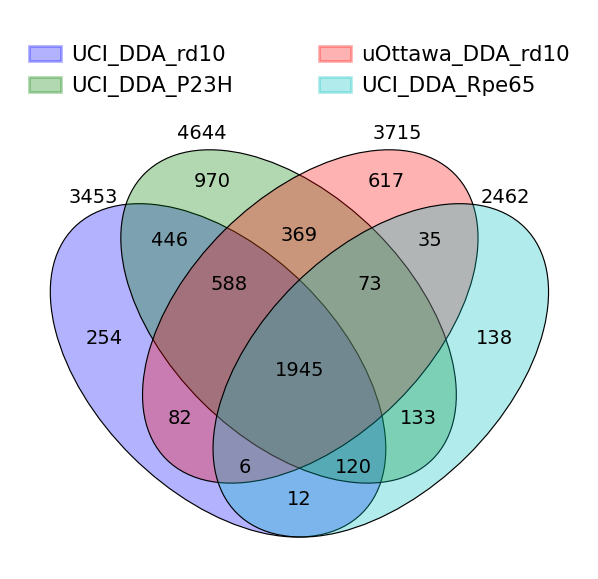

In [14]:
# Now estimate the number of quantified proteins in Synapse data sets and select only those proteins
# which are quantified in all 4 data sets 

banned_columns = set(
['group', 'condition', 'sample', 'replicate', 'BatchMS', 'vs', 'sample+condition'])

prot_cnt = Counter()
prot_all_batches = set()
prot_by_dataset = defaultdict(set)

n_BatchOrig = len(set(df1['BatchOrig']))
for BatchOrig in set(df1['BatchOrig']):   
    i_cnt = 0
    oname = 'DQ2_2024_%s_proteins_LFQ.tsv' % (BatchOrig, )
    dft = pd.read_table(os.path.join(infolder, oname))
    for cc in dft.columns:
        if cc not in banned_columns:
            if cc != 'File Name':
                prot_by_dataset[BatchOrig].add(cc)
            prot_cnt[cc] += 1
            i_cnt += 1
    print(BatchOrig, i_cnt)
            
for k, v in prot_cnt.items():
    if v >= 6:
        prot_all_batches.add(k)
print('Total number of proteins: %d' % (len(prot_cnt) - 1, ))
print('Proteins in all datasets: %d' % (len(prot_all_batches) - 1, ))

sets = {
    'UCI_DDA_rd10': prot_by_dataset['UCI_DDA_rd10'],
    'UCI_DDA_P23H': prot_by_dataset['UCI_DDA_P23H'],
#     'UEF_DIA_P23H': prot_by_dataset['UEF_DIA_P23H'],
#     'UEF_DIA_rd10': prot_by_dataset['UEF_DIA_rd10'],
    'uOttawa_DDA_rd10': prot_by_dataset['uOttawa_DDA_rd10'],
    'UCI_DDA_Rpe65': prot_by_dataset['UCI_DDA_Rpe65']}
    
venny4py.venny4py(sets=sets)

In [15]:
# Update loaded sample tables with protein LFQ information

dft_common = False
for BatchOrig in set(df1['BatchOrig']):
    i_cnt = 0
    oname = 'DQ2_2024_%s_proteins_LFQ.tsv' % (BatchOrig, )
    dft = pd.read_table(os.path.join(infolder, oname))
    print(BatchOrig)
    dft = dft[[cc for cc in dft.columns if cc in prot_all_batches]]
    if dft_common is False:
        dft_common = dft.copy()
    else:
        dft_common = pd.concat([dft_common, dft], ignore_index=True)
df1 = pd.merge(df1, dft_common, on='File Name', how='left')

UCI_DDA_Rpe65
UCI_DDA_P23H
uOttawa_DDA_rd10
UEF_DIA_P23H
UEF_DIA_rd10
UCI_DDA_rd10


In [16]:
df1_orig = df1.copy()

In [ ]:
# Auxilary functions to train ML models

TARGET_NAME = "local_target"
PREDICTION_NAME = "prediction"

def get_X_array(df, feature_columns):
    return df.loc[:, feature_columns].fillna(0).values

def get_features(dataframe, allowed_features=False):
    feature_columns = dataframe.columns
    columns_to_remove = []
    for feature in feature_columns:
        if feature != 'Sex' and not feature.startswith('sp|'):
            columns_to_remove.append(feature)
        if allowed_features is not False and feature not in allowed_features:
            columns_to_remove.append(feature)
    feature_columns = feature_columns.drop(columns_to_remove)
    return list(feature_columns)


def get_Y_array(df):
    return df.loc[:, 'local_target'].values

def get_cat_model_final(df, hyperparameters, feature_columns):
    clf = ExtraTreesRegressor(n_estimators=hyperparameters['n_estimators'],
                                     max_depth=hyperparameters['max_depth'], random_state=0,
                                     min_samples_leaf=hyperparameters['min_samples_leaf'],
                                    min_groups_leaf = hyperparameters['min_groups_leaf'],
                                    min_weight_groups = hyperparameters['min_weight_groups'],
                                    min_samples_split = hyperparameters['min_samples_split'],
                                    n_jobs = hyperparameters['n_jobs'], max_features = hyperparameters['max_features']
                                    )    
    train = df
    X_train = get_X_array(train, feature_columns)
    y_train = get_Y_array(train)
    groups_train = train['G'].values
    sw_train = train['W'].values
    clf.fit(X_train, y_train, sample_weight=sw_train, groups=groups_train.astype(np.int32))
    return clf

def calc_arrays_kfold(mdi_res2):
    
    all_names = []
    all_a = []
    all_l = []
    all_bb0 = []
#     ii_range = np.array([0, 1, 2, 3])
    ii_range = np.array([0, 1, 2, ])

    useful_features = set()
    for k in mdi_res2.keys():
        vbase = [np.mean(mdi_res2[k][ii]) for ii in ii_range+1]
        a, b, R2, std_val = aux.linear_regression(ii_range, vbase)
        diff_ar = np.diff(vbase)
        diff_ar = np.clip(diff_ar, a_min=None, a_max=0)
        max_dropdown = np.abs(diff_ar).max()/max(1e-10, b)
        all_l.append(vbase[-1])
        all_bb0.append(max_dropdown)
        all_names.append(k)
        all_a.append(a * 1000)

    all_a = np.array(all_a)
    all_names = np.array(all_names)
    all_l = np.log10(all_l)
    all_bb0 = np.array(all_bb0)
    idx_sort = np.argsort(-all_l)
    all_names = all_names[idx_sort]
    all_a = all_a[idx_sort]
    all_l = all_l[idx_sort]
    all_bb0 = all_bb0[idx_sort]

    return all_names, all_a, all_l, all_bb0

def calibrate_RT_gaus(bwidth, mass_left, mass_right, true_md):

    bbins = np.arange(-mass_left, mass_right, bwidth)
    H1, b1 = np.histogram(true_md, bins=bbins)
    b1 = b1 + bwidth
    b1 = b1[:-1]


    popt, pcov = curve_fit(noisygaus, b1, H1, p0=[1, np.median(true_md), bwidth * 5, 1], maxfev = 10000)
    mass_shift, mass_sigma = popt[1], abs(popt[2])
    return mass_shift, mass_sigma, pcov[0][0]

def calibrate_RT_gaus_full(rt_diff_tmp):
    RT_left = -min(rt_diff_tmp)
    RT_right = max(rt_diff_tmp)

    try:
        start_width = (scoreatpercentile(rt_diff_tmp, 95) - scoreatpercentile(rt_diff_tmp, 5)) / 100
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(start_width, RT_left, RT_right, rt_diff_tmp)
    except:
        start_width = (scoreatpercentile(rt_diff_tmp, 95) - scoreatpercentile(rt_diff_tmp, 5)) / 50
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(start_width, RT_left, RT_right, rt_diff_tmp)
    if np.isinf(covvalue):
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(0.1, RT_left, RT_right, rt_diff_tmp)
    if np.isinf(covvalue):
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(1.0, RT_left, RT_right, rt_diff_tmp)
    return XRT_shift, XRT_sigma, covvalue

def noisygaus(x, a, x0, sigma, b):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + b


bestparams_base = {'max_depth': 6,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_groups_leaf': 1,
 'min_weight_groups': 0,
 'n_estimators': 1000,
 'max_features': None,
 'n_jobs': 10}

Below we are doing two types of analysis:
    1. Find proteins with common patterns for (Rpe65, P23H and rd10) groups vs Control
    2. Find proteins with common patterns for (P23H and rd10) groups vs (Control + Rpe65)

In [36]:
# Train models using k-fold CV described in the manuscript
# Here we train models which differ combined Rpe65, P23H and rd10 groups together vs Control

num_cv_folds = len(set(df1['G']))
ii_range = list([xx+1 for xx in range(num_cv_folds-1)])[::-1]

res_list = dict()
a_dict = dict()


# all_cond = ['RD_vs_LCA2', 'RD_vs_Control', 'LCA2_vs_Control']



all_cond = ['RD_vs_Control', ]
for cond in all_cond:
    
    if cond == 'RD_vs_Control':
        ltn_map = {
            'RD': 1,
            'Control': 0,
        }
        dfn = df1.copy()
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
        
    else:
        print('unknown condition')
        break
        
    dfn['G'] = dfn['Batch']+1
    gcount = Counter(dfn['G'])
    dfn['W'] = 1

    base_scores = defaultdict(list)
    a_dict[cond] = defaultdict(list)
    filename_to_fold_map = {}
    SEED = 42
    
    for kfold_g in range(1, num_cv_folds+1, 1):
        train_df_c = dfn[dfn['G'].apply(lambda x: x != kfold_g)].copy()
        test_df_c = dfn[dfn['G'].apply(lambda x: x == kfold_g)].copy()

        train_df_c['W'] = 1.0

        mdi_res2 = defaultdict(list)
        mdi_res2 = dict()
        min_w_values2 = []

        feature_columns = get_features(dfn)
        for fn in feature_columns:
            mdi_res2[fn] = defaultdict(list)
    

#         for ii in [3, 2, 1, ]:
        for ii in ii_range:
            bestparams = copy(bestparams_base)
            bestparams['min_groups_leaf'] = ii

            rfr = get_cat_model_final(train_df_c, bestparams, feature_columns)
            
            xarr = get_X_array(test_df_c, feature_columns)
            yarr = get_Y_array(test_df_c)
            base_preds = rfr.predict(xarr)
            
            if 'Ranked' in cond:
                base_score = np.corrcoef(rankdata(yarr, method='min'), rankdata(base_preds, method='min'))[0][1]
            else:
                base_score = roc_auc_score(yarr, base_preds)
            base_scores[ii].append(base_score)

            cnt_check = 0
            min_w_values2.append(ii)
            fn_fi_array = sorted(list(zip(range(len(feature_columns)), feature_columns, rfr.feature_importances_)), key=lambda x: -x[2])
            for ftr_idx, fn, fv in fn_fi_array:
                cnt_check += 1
                mdi_res2[fn][ii].append(fv)
                        
        all_names, all_a, all_l, all_bb0 = calc_arrays_kfold(mdi_res2)
        idx_sort = np.argsort(-all_l)
        for k, a in zip(all_names[idx_sort], all_a[idx_sort]):              
            a_dict[cond][k].append(a)
                
    res_list[cond] = (mdi_res2, '', base_scores)
    print(cond + ' was finished' + '\n')

RD_vs_Control was finished



In [37]:
# Print AUC values for (K-fold, All features)

num_cv_folds = len(set(df1['G']))
ii_range = list([xx+1 for xx in range(num_cv_folds-1)])[::-1]

for cond in res_list.keys():
    if not cond.startswith('Ranked'):
        base_scores = res_list[cond][2]
        print('\n' + cond)
#         for mgl in [1, 2, 3]:
        for mgl in ii_range[::-1]:
            mn_auc = np.mean(base_scores[mgl])
            std_auc = np.std(base_scores[mgl])
            if mgl == 1:
                pval_auc = 1.0
            else:
                try:
                    pval_auc = wilcoxon(base_scores[mgl], base_scores[1])[1]
                except:
                    pval_auc = 1.0
            print('min_groups_leaf', mgl, '%.3f / %.3f / %.3f' % (mn_auc, std_auc, pval_auc))


RD_vs_Control
min_groups_leaf 1 1.000 / 0.000 / 1.000
min_groups_leaf 2 0.998 / 0.005 / 0.317
min_groups_leaf 3 0.998 / 0.005 / 0.317
min_groups_leaf 4 0.998 / 0.005 / 0.317
min_groups_leaf 5 0.998 / 0.005 / 0.317


In [38]:
# Print Proteins significant for the generalizability of the models as described in the manuscript
# Report the probabilities defined by Eq. 2 in the manuscript

feature_columns3_multicond = defaultdict(set)
for cond in a_dict.keys():
    print(cond)
        
    ar1 = defaultdict(list)    
    ar2 = dict()
    ar2_shift = dict()
    ar3 = defaultdict(list)
    ar_names = []
    for kk, vv in a_dict[cond].items():
        for iii in range(len(vv)):
            ar1[iii].append(vv[iii])
        ar_names.append(kk)

    for iii in ar1.keys():
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus_full(ar1[iii])
        ar2[iii] = XRT_sigma
        ar2_shift[iii] = XRT_shift
    
    for iii in ar2.keys():
        for v in ar1[iii]:
            ar3[iii].append(scipy.stats.norm.sf((v-ar2_shift[iii])/ar2[iii]))
            
    p_values = []
    for idx in range(len(ar_names)):
        p_values.append(1 - np.prod([1 - ar3[iii][idx] for iii in ar3.keys()]))
        
    ar_names = np.array(ar_names)
    for k, pval in sorted(list(zip(ar_names, p_values)), key=lambda x: x[1]):
        if pval <= 0.05:
            print(k, '\t', pval)
            feature_columns3_multicond[cond].add(k)

    print('\n\n')
    
for cond in feature_columns3_multicond.keys():
    feature_columns3_multicond[cond] = list(feature_columns3_multicond[cond])

RD_vs_Control
sp|P03995|GFAP_MOUSE 	 0.0
sp|Q61553|FSCN1_MOUSE 	 0.0
sp|Q8BTM8|FLNA_MOUSE 	 0.0
sp|Q9WV54|ASAH1_MOUSE 	 0.0
sp|Q8R0Y6|AL1L1_MOUSE 	 0.0
sp|P20152|VIME_MOUSE 	 0.0
sp|Q9QXS1|PLEC_MOUSE 	 0.0
sp|P27773|PDIA3_MOUSE 	 0.0
sp|Q9CYT6|CAP2_MOUSE 	 0.0
sp|P45591|COF2_MOUSE 	 0.0
sp|O88935|SYN1_MOUSE 	 0.0
sp|P08226|APOE_MOUSE 	 0.0
sp|Q60676|PPP5_MOUSE 	 0.0
sp|Q9D1G1|RAB1B_MOUSE 	 0.0
sp|P62281|RS11_MOUSE 	 0.0
sp|P45376|ALDR_MOUSE 	 0.0
sp|Q8BRT1|CLAP2_MOUSE 	 0.0
sp|Q9ERL9|GCYA1_MOUSE 	 0.0
sp|P16381|DDX3L_MOUSE 	 0.0
sp|Q8R001|MARE2_MOUSE 	 0.0
sp|P50446|K2C6A_MOUSE 	 0.0
sp|Q60575|KIF1B_MOUSE 	 1.7872082702652392e-09
sp|O08915|AIP_MOUSE 	 3.461902831070063e-08
sp|B2RSH2|GNAI1_MOUSE 	 3.461902831070063e-08
sp|Q9WV92|E41L3_MOUSE 	 9.746133198373919e-06





In [42]:
# Extract proteins which are common for ALL 3 groups: Rpe65, P23H and rd10 

print('%s\t%s\t%s\t%s\t%s\t%s' % ('Model', 'dbname', 'p-value vs Rpe65', 'p-value vs Ctrl', 'Median FC in RP', 'Median FC in Rpe65'))
tmp = df1.copy()
total_ML_proteins = set()
for cond in feature_columns3_multicond.keys():
    for prot in feature_columns3_multicond[cond]:
        total_ML_proteins.add(prot)
        ar_asym = tmp[(tmp['cohort'] != 'Rpe65') & (tmp['Group'] == 'RD')][prot].values
        ar_ad = tmp[(tmp['cohort'] == 'Rpe65') & (tmp['Group'] == 'RD')][prot].values
        ar_control = tmp[tmp['Group'] == 'Control'][prot].values
        p_vs_ad = ttest_ind(ar_asym, ar_ad)[1]
        p_vs_ctl = ttest_ind(ar_asym, ar_control)[1]
        p_ad_vs_ctl = ttest_ind(ar_ad, ar_control)[1]
        fc_asym = np.median(ar_asym)
        fc_ad = np.median(ar_ad)
        fc_control = np.median(ar_control)
#         if abs(fc_asym) >= 0.05 and (abs(fc_asym/fc_ad) >= 5 or np.sign(fc_asym) != np.sign(fc_ad)):
        print('%s\t%s\t%.4f\t%.4f\t%.2f\t%.2f' % (cond, prot, p_vs_ad, p_vs_ctl, fc_asym, fc_ad))
            
print('\n\n', len(total_ML_proteins))

Model	dbname	p-value vs Rpe65	p-value vs Ctrl	Median FC in RP	Median FC in Rpe65
RD_vs_Control	sp|P16381|DDX3L_MOUSE	0.0018	0.0000	0.39	0.04
RD_vs_Control	sp|Q8R0Y6|AL1L1_MOUSE	0.0440	0.0000	0.74	0.34
RD_vs_Control	sp|Q9D1G1|RAB1B_MOUSE	0.2339	0.0000	0.46	0.26
RD_vs_Control	sp|Q8BRT1|CLAP2_MOUSE	0.9058	0.0000	0.31	0.23
RD_vs_Control	sp|P27773|PDIA3_MOUSE	0.0001	0.0000	0.55	0.15
RD_vs_Control	sp|Q9QXS1|PLEC_MOUSE	0.6977	0.0000	0.31	0.28
RD_vs_Control	sp|Q8BTM8|FLNA_MOUSE	0.3757	0.0000	0.53	0.43
RD_vs_Control	sp|Q9CYT6|CAP2_MOUSE	0.1561	0.0000	0.45	0.61
RD_vs_Control	sp|P45376|ALDR_MOUSE	0.0175	0.0000	0.60	0.33
RD_vs_Control	sp|O88935|SYN1_MOUSE	0.0000	0.0000	0.58	-0.09
RD_vs_Control	sp|O08915|AIP_MOUSE	0.0000	0.0002	0.23	-0.94
RD_vs_Control	sp|Q9WV92|E41L3_MOUSE	0.5406	0.0000	0.40	0.34
RD_vs_Control	sp|P03995|GFAP_MOUSE	0.0001	0.0000	2.33	1.09
RD_vs_Control	sp|Q60575|KIF1B_MOUSE	0.6902	0.0000	0.35	0.31
RD_vs_Control	sp|Q60676|PPP5_MOUSE	0.0127	0.0000	0.20	0.57
RD_vs_Control	sp|P45591|CO

<Figure size 1280x960 with 0 Axes>

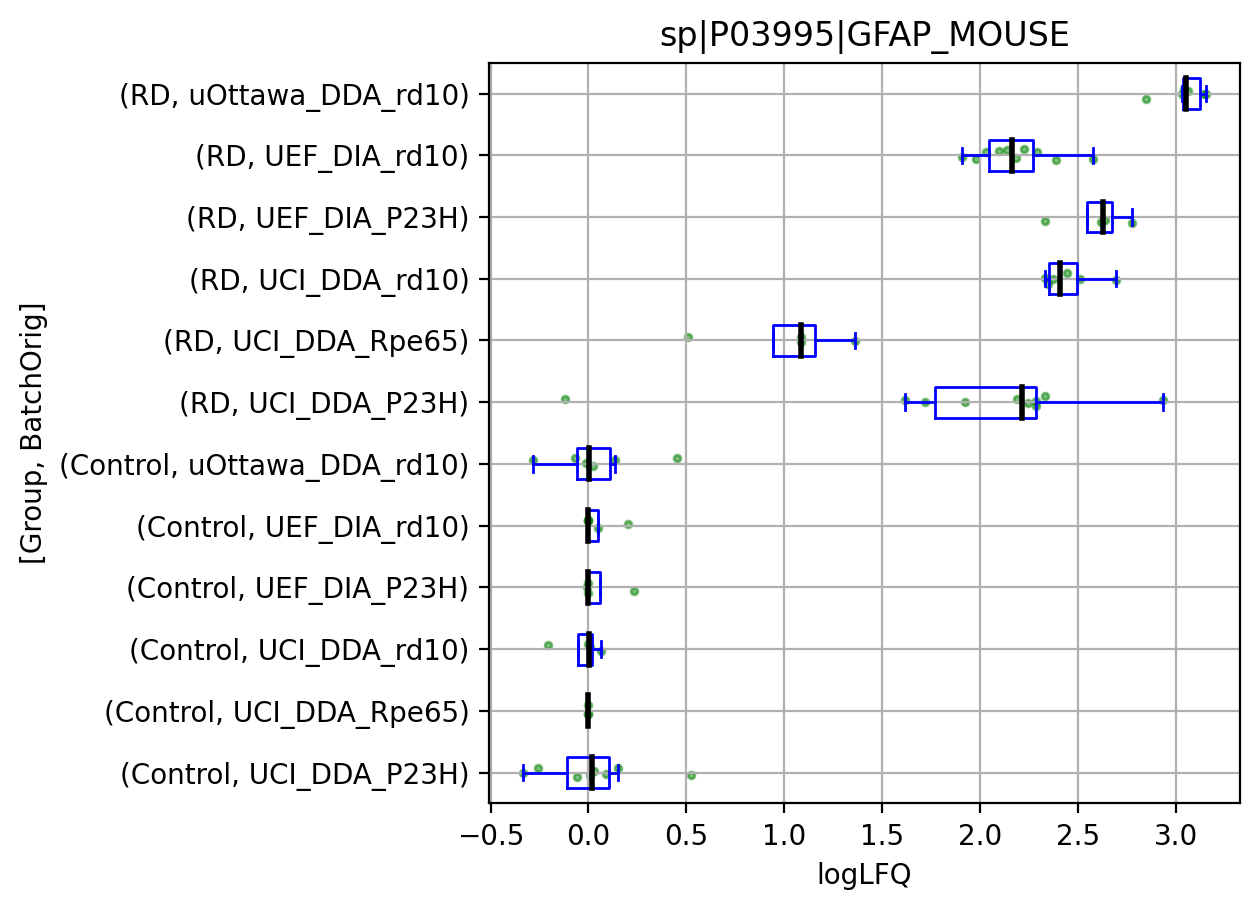

In [40]:
# Plot figure for one of the interesting proteins

groupings = [
#     ['Group', ],
    ['Group', 'BatchOrig'],
]

prot_name = 'sp|P03995|GFAP_MOUSE'
# tmp = df1.copy()
tmp = df1_orig.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()
# plt.savefig('/home/mark/shared/SETP7_MOUSE_LFQ.png', facecolor='white', dpi=300)



<Figure size 1280x960 with 0 Axes>

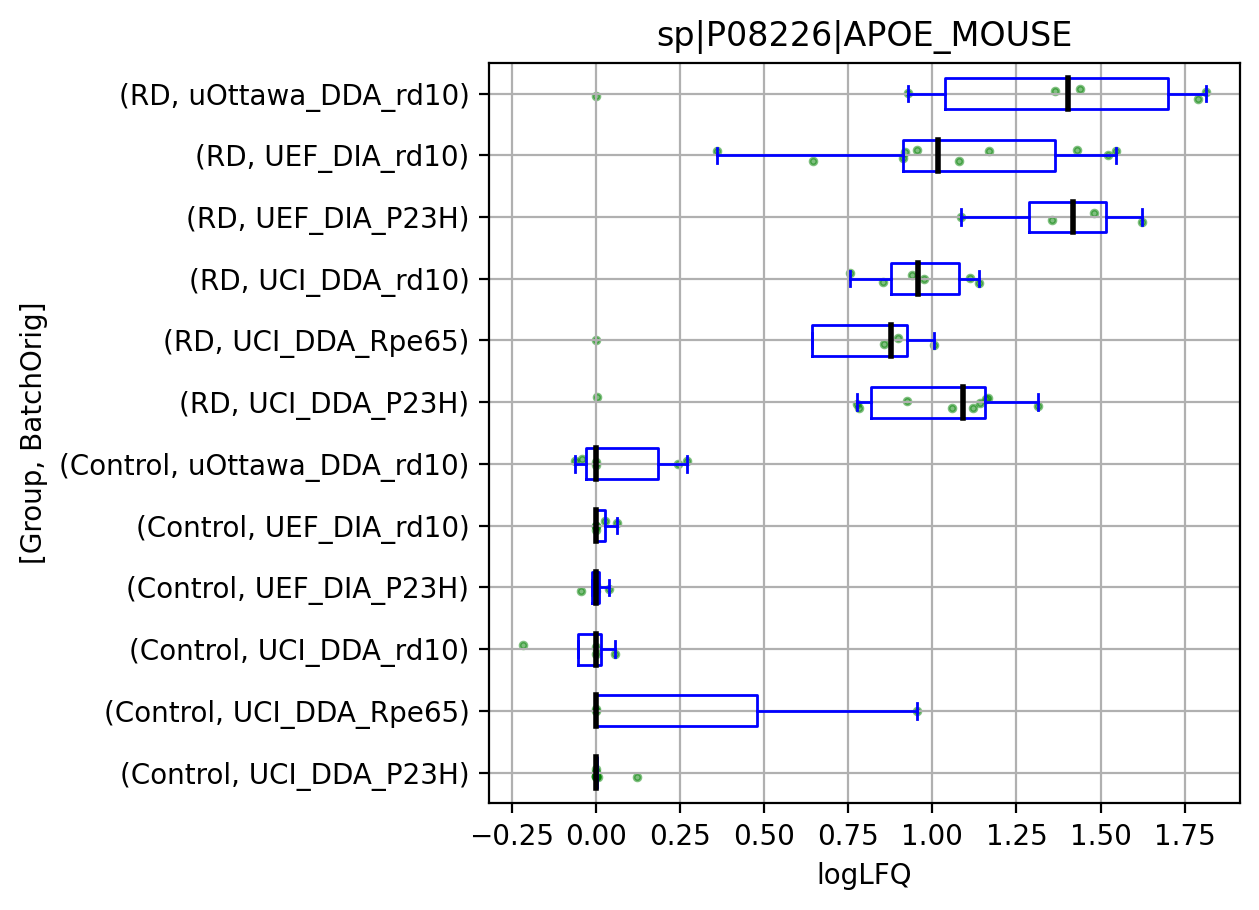

In [43]:
# Plot figure for one of the interesting proteins

groupings = [
#     ['Group', ],
    ['Group', 'BatchOrig'],
]

prot_name = 'sp|P08226|APOE_MOUSE'
# tmp = df1.copy()
tmp = df1_orig.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()
# plt.savefig('/home/mark/shared/SETP7_MOUSE_LFQ.png', facecolor='white', dpi=300)



In [ ]:
df1 = df1_orig.copy()

In [24]:
# Below we do a trick to extend all data sets for P23H and rd10 mutations with Rpe65 data
# We want to train model below which differentiate RD related to P23H and rd10 versus both Control and Rpe65 samples
tmps = df1[df1['BatchOrig'] == 'UCI_DDA_Rpe65'].copy()
g_Rpe65 = tmps['G'].values[0]
Batch_Rpe65 = tmps['Batch'].values[0]

df1 = df1[df1['BatchOrig'] != 'UCI_DDA_Rpe65'].copy()
df1.loc[df1['G'] == df1['G'].max(), 'G'] = g_Rpe65
df1.loc[df1['Batch'] == df1['Batch'].max(), 'Batch'] = Batch_Rpe65

for bo in set(df1['BatchOrig']):
    tmps['BatchOrig'] = bo
    df1 = df1.append(tmps, ignore_index=True)
    
df1.loc[df1['cohort'] == 'Rpe65', 'Group'] = 'Control'

In [27]:
# Train models using k-fold CV described in the manuscript
# Here we train models which differ combined P23H and rd10 groups together vs (Control + Rpe65)

num_cv_folds = len(set(df1['G']))
ii_range = list([xx+1 for xx in range(num_cv_folds-1)])[::-1]

res_list = dict()
a_dict = dict()


# all_cond = ['RD_vs_LCA2', 'RD_vs_Control', 'LCA2_vs_Control']



all_cond = ['RD_vs_Control', ]
for cond in all_cond:
    
    if cond == 'RD_vs_Control':
        ltn_map = {
            'RD': 1,
            'Control': 0,
        }
        dfn = df1.copy()
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
        
    else:
        print('unknown condition')
        break
        
    dfn['G'] = dfn['Batch']+1
    gcount = Counter(dfn['G'])
    dfn['W'] = 1

    base_scores = defaultdict(list)
    a_dict[cond] = defaultdict(list)
    filename_to_fold_map = {}
    SEED = 42
    
    for kfold_g in range(1, num_cv_folds+1, 1):
        train_df_c = dfn[dfn['G'].apply(lambda x: x != kfold_g)].copy()
        test_df_c = dfn[dfn['G'].apply(lambda x: x == kfold_g)].copy()

        train_df_c['W'] = 1.0

        mdi_res2 = defaultdict(list)
        mdi_res2 = dict()
        min_w_values2 = []

        feature_columns = get_features(dfn)
        for fn in feature_columns:
            mdi_res2[fn] = defaultdict(list)
    

#         for ii in [3, 2, 1, ]:
        for ii in ii_range:
            bestparams = copy(bestparams_base)
            bestparams['min_groups_leaf'] = ii

            rfr = get_cat_model_final(train_df_c, bestparams, feature_columns)
            
            xarr = get_X_array(test_df_c, feature_columns)
            yarr = get_Y_array(test_df_c)
            base_preds = rfr.predict(xarr)
            
            if 'Ranked' in cond:
                base_score = np.corrcoef(rankdata(yarr, method='min'), rankdata(base_preds, method='min'))[0][1]
            else:
                base_score = roc_auc_score(yarr, base_preds)
            base_scores[ii].append(base_score)

            cnt_check = 0
            min_w_values2.append(ii)
            fn_fi_array = sorted(list(zip(range(len(feature_columns)), feature_columns, rfr.feature_importances_)), key=lambda x: -x[2])
            for ftr_idx, fn, fv in fn_fi_array:
                cnt_check += 1
                mdi_res2[fn][ii].append(fv)
                        
        all_names, all_a, all_l, all_bb0 = calc_arrays_kfold(mdi_res2)
        idx_sort = np.argsort(-all_l)
        for k, a in zip(all_names[idx_sort], all_a[idx_sort]):              
            a_dict[cond][k].append(a)
                
    res_list[cond] = (mdi_res2, '', base_scores)
    print(cond + ' was finished' + '\n')

RD_vs_Control was finished



In [28]:
# Print AUC values for (K-fold, All features)

num_cv_folds = len(set(df1['G']))
ii_range = list([xx+1 for xx in range(num_cv_folds-1)])[::-1]

for cond in res_list.keys():
    if not cond.startswith('Ranked'):
        base_scores = res_list[cond][2]
        print('\n' + cond)
#         for mgl in [1, 2, 3]:
        for mgl in ii_range[::-1]:
            mn_auc = np.mean(base_scores[mgl])
            std_auc = np.std(base_scores[mgl])
            if mgl == 1:
                pval_auc = 1.0
            else:
                try:
                    pval_auc = wilcoxon(base_scores[mgl], base_scores[1])[1]
                except:
                    pval_auc = 1.0
            print('min_groups_leaf', mgl, '%.3f / %.3f / %.3f' % (mn_auc, std_auc, pval_auc))


RD_vs_Control
min_groups_leaf 1 0.997 / 0.005 / 1.000
min_groups_leaf 2 1.000 / 0.000 / 0.317
min_groups_leaf 3 0.997 / 0.005 / 1.000
min_groups_leaf 4 1.000 / 0.000 / 0.317


In [29]:
# Print Proteins significant for the generalizability of the models as described in the manuscript
# Report the probabilities defined by Eq. 2 in the manuscript

feature_columns3_multicond = defaultdict(set)
for cond in a_dict.keys():
    print(cond)
        
    ar1 = defaultdict(list)    
    ar2 = dict()
    ar2_shift = dict()
    ar3 = defaultdict(list)
    ar_names = []
    for kk, vv in a_dict[cond].items():
        for iii in range(len(vv)):
            ar1[iii].append(vv[iii])
        ar_names.append(kk)

    for iii in ar1.keys():
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus_full(ar1[iii])
        ar2[iii] = XRT_sigma
        ar2_shift[iii] = XRT_shift
    
    for iii in ar2.keys():
        for v in ar1[iii]:
            ar3[iii].append(scipy.stats.norm.sf((v-ar2_shift[iii])/ar2[iii]))
            
    p_values = []
    for idx in range(len(ar_names)):
        p_values.append(1 - np.prod([1 - ar3[iii][idx] for iii in ar3.keys()]))
        
    ar_names = np.array(ar_names)
    for k, pval in sorted(list(zip(ar_names, p_values)), key=lambda x: x[1]):
        if pval <= 0.05:
            print(k, '\t', pval)
            feature_columns3_multicond[cond].add(k)

    print('\n\n')
    
for cond in feature_columns3_multicond.keys():
    feature_columns3_multicond[cond] = list(feature_columns3_multicond[cond])

RD_vs_Control
sp|P18242|CATD_MOUSE 	 0.0
sp|P57780|ACTN4_MOUSE 	 0.0
sp|Q8K0U4|HS12A_MOUSE 	 0.0
sp|Q01768|NDKB_MOUSE 	 0.0
sp|O55131|SEPT7_MOUSE 	 0.0
sp|O54983|CRYM_MOUSE 	 0.0
sp|Q9WUB3|PYGM_MOUSE 	 0.0
sp|Q00915|RET1_MOUSE 	 0.0
sp|O35098|DPYL4_MOUSE 	 0.0
sp|P48678|LMNA_MOUSE 	 0.0
sp|Q5XG69|F169A_MOUSE 	 0.0
sp|Q9QYR6|MAP1A_MOUSE 	 0.0
sp|Q9EQF6|DPYL5_MOUSE 	 0.0





In [30]:
# Extract proteins which are common for 2 groups: P23H and rd10 but have different FC in both Control and Rpe65 

print('%s\t%s\t%s\t%s\t%s\t%s' % ('Model', 'dbname', 'p-value vs Rpe65', 'p-value vs Ctrl', 'Median FC in RP', 'Median FC in Rpe65'))
tmp = df1.copy()
total_ML_proteins = set()
for cond in feature_columns3_multicond.keys():
    for prot in feature_columns3_multicond[cond]:
        total_ML_proteins.add(prot)
        ar_asym = tmp[(tmp['cohort'] != 'Rpe65') & (tmp['Group'] == 'RD')][prot].values
        ar_ad = tmp[(tmp['cohort'] == 'Rpe65') & (tmp['Group'] == 'Control')][prot].values
        ar_control = tmp[tmp['Group'] == 'Control'][prot].values
        p_vs_ad = ttest_ind(ar_asym, ar_ad)[1]
        p_vs_ctl = ttest_ind(ar_asym, ar_control)[1]
        p_ad_vs_ctl = ttest_ind(ar_ad, ar_control)[1]
        fc_asym = np.median(ar_asym)
        fc_ad = np.median(ar_ad)
        fc_control = np.median(ar_control)
        if abs(fc_asym) >= 0.05 and (abs(fc_asym/fc_ad) >= 5 or np.sign(fc_asym) != np.sign(fc_ad)):
            print('%s\t%s\t%.4f\t%.4f\t%.2f\t%.2f' % (cond, prot, p_vs_ad, p_vs_ctl, fc_asym, fc_ad))
            
print('\n\n', len(total_ML_proteins))

Model	dbname	p-value vs Rpe65	p-value vs Ctrl	Median FC in RP	Median FC in Rpe65
RD_vs_Control	sp|O55131|SEPT7_MOUSE	0.0000	0.0000	0.51	-0.05
RD_vs_Control	sp|Q9WUB3|PYGM_MOUSE	0.0000	0.0000	0.76	-0.59
RD_vs_Control	sp|O35098|DPYL4_MOUSE	0.0000	0.0000	0.59	0.00
RD_vs_Control	sp|Q01768|NDKB_MOUSE	0.0000	0.0000	0.83	-0.35
RD_vs_Control	sp|O54983|CRYM_MOUSE	0.0000	0.0000	1.32	-0.13
RD_vs_Control	sp|Q8K0U4|HS12A_MOUSE	0.0000	0.0000	0.56	-0.72
RD_vs_Control	sp|Q00915|RET1_MOUSE	0.0000	0.0000	1.09	-0.87
RD_vs_Control	sp|P48678|LMNA_MOUSE	0.0000	0.0000	0.66	0.00
RD_vs_Control	sp|Q9EQF6|DPYL5_MOUSE	0.0000	0.0000	0.57	-0.18
RD_vs_Control	sp|P57780|ACTN4_MOUSE	0.0000	0.0000	0.57	-0.30
RD_vs_Control	sp|P18242|CATD_MOUSE	0.0000	0.0000	0.75	-0.29


 13


<Figure size 1280x960 with 0 Axes>

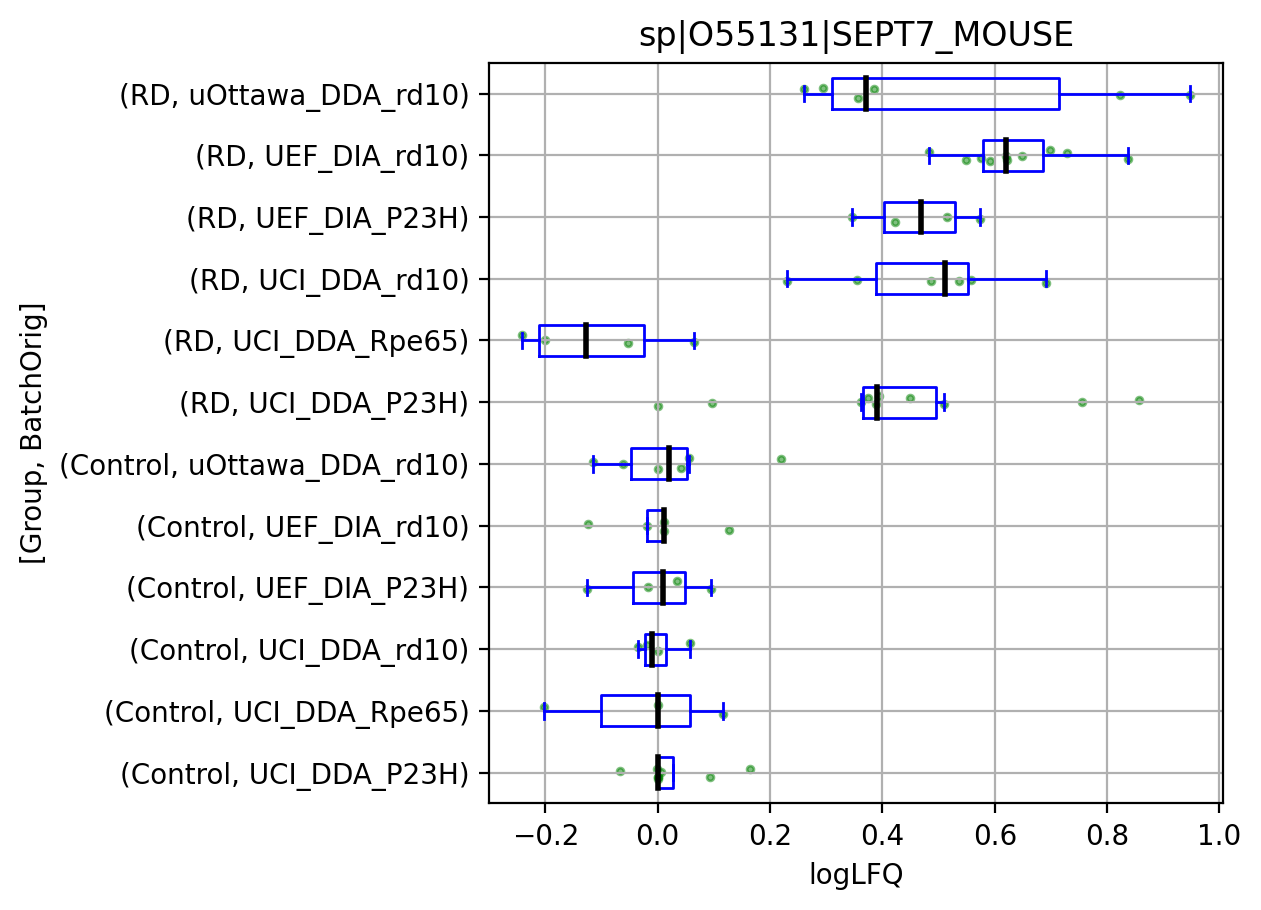

In [32]:
# Plot figure for one of the interesting proteins

groupings = [
#     ['Group', ],
    ['Group', 'BatchOrig'],
]

prot_name = 'sp|O55131|SEPT7_MOUSE'
# tmp = df1.copy()
tmp = df1_orig.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()
# plt.savefig('/home/mark/shared/SETP7_MOUSE_LFQ.png', facecolor='white', dpi=300)



<Figure size 1280x960 with 0 Axes>

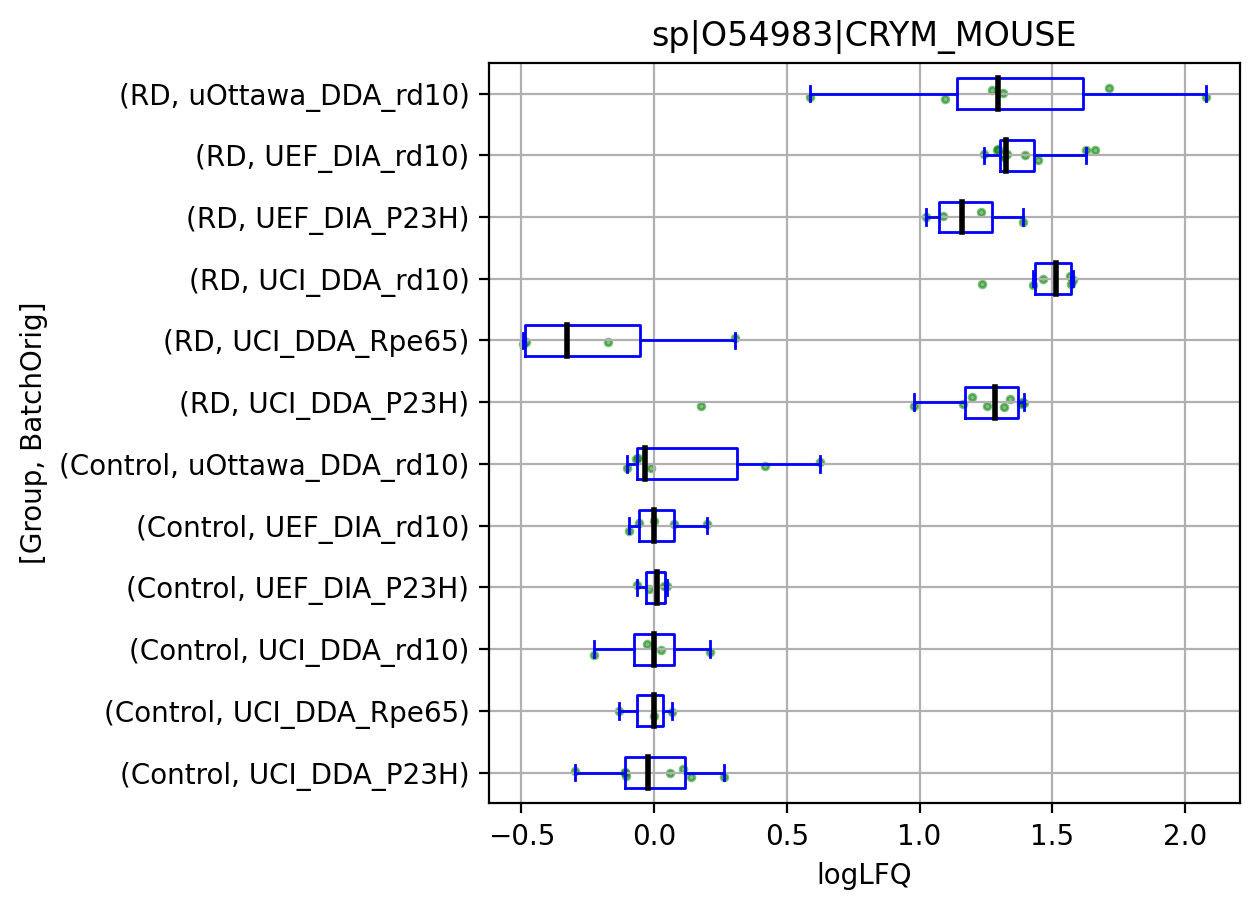

In [33]:
# Plot figure for one of the interesting proteins

groupings = [
#     ['Group', ],
    ['Group', 'BatchOrig'],
]

prot_name = 'sp|O54983|CRYM_MOUSE'
# tmp = df1.copy()
tmp = df1_orig.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()
# plt.savefig('/home/mark/shared/CRYM_MOUSE_LFQ.png', facecolor='white', dpi=300)



<Figure size 1280x960 with 0 Axes>

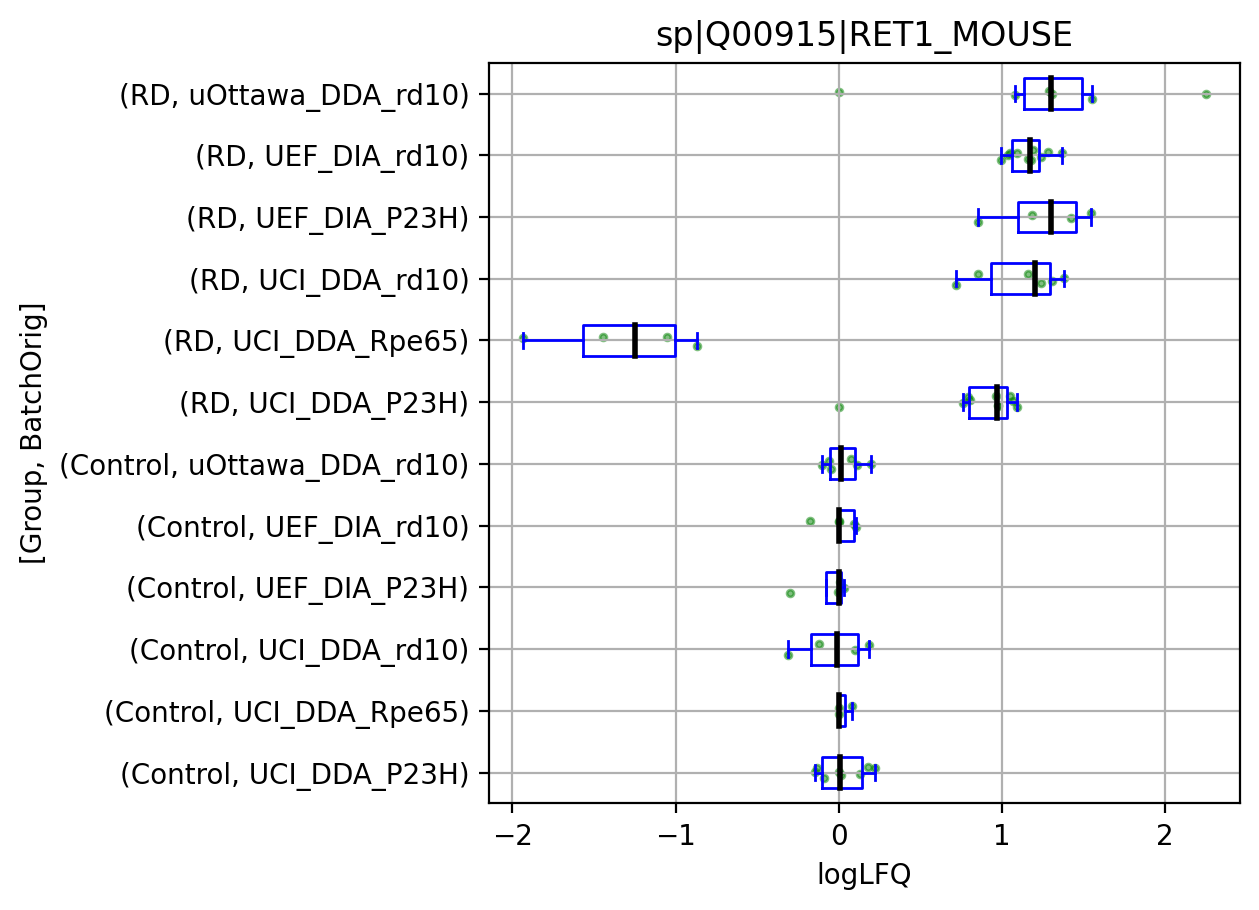

In [34]:
# Plot figure for one of the interesting proteins

groupings = [
#     ['Group', ],
    ['Group', 'BatchOrig'],
]

prot_name = 'sp|Q00915|RET1_MOUSE'
# tmp = df1.copy()
tmp = df1_orig.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()
# plt.savefig('/home/mark/shared/RET1_MOUSE_LFQ.png', facecolor='white', dpi=300)

